In [1]:
import numpy as np
alldeploys=["Wizard","ManaTower","Executioner","Ghost"]
allabilities=["Fireball","Execute","Haunt"]
allnotarget=["HealSpell","ExorcismSpell"]
allmoves=['EndTurn']
alldeploysquares=[]
allhandcards=alldeploys+allnotarget
for card in alldeploys:
    alldeploysquares.extend([card+str(x) for x in range(4)])
allmoves.extend(alldeploysquares)
for move in allabilities:
    allmoves.extend([move+str(x) for x in range(4)])
allmoves.extend([allnotarget[x] for x in range(2)])
def encodehand(hand,length=len(allhandcards)):
    small=len(allhandcards)
    return [hand.count(x) if x in hand else 0 for x in allhandcards]+[0]*max(0,length-small)
def encodemove(move,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x==move else 0 for x in allmoves]+[0]*max(0,length-small)
def encodemoves(moves,length=len(allmoves)):
    small=len(allmoves)
    return [1 if x in moves else 0 for x in allmoves]+[0]*max(0,length-small)
def encodedeployed(troops,length=len(alldeploysquares)):
    small=len(alldeploysquares)
    return [1 if x in troops else 0 for x in alldeploysquares]+[0]*max(0,length-small)
def encodehealths(troops):

    return [troop.health if hasattr(troop,"health") else 0 for troop in troops]+[0]*(4-len(troops))



In [2]:
# -----------------------------
# Game controller
# -----------------------------
class Game:
    def __init__(self, player_1, player_2, length=10, prnt=True, offset=[0,2],show=False):
        self.turn = 0
        self.prnt = prnt
        self.moves_played = 0
        self.length = length
        self.game_over = False
        self.players = [player_1, player_2]
        player_1.game = self
        player_2.game = self
        player_1.team = 0
        player_2.team = 1
        player_2.base_health += offset[0]
        player_2.mana += offset[1]
        self.boards=[]
        self.show=show
        self.player_1=player_1
        self.player_2=player_2
    def change_turn(self):
        self.turn = 1 - self.turn

    def play(self):
        while self.moves_played < self.length and not self.game_over:
            player = self.players[self.turn]
            opponent = self.players[self.turn-1]
            if self.prnt:
                print(f"\n--- Turn {self.moves_played}, Player {self.turn+1} ---")
            player.make_move(self)
            if self.show:
                self.show_board()
            
        return self.end_game()

    def end_game(self):
        p1, p2 = self.players
        if p1.base_health > p2.base_health:
            return 1
        elif p1.base_health < p2.base_health:
            return -1
        return 0
    def show_board(self):
        print("----------------------------------------------")
        print("Current Board:")
        print(f"Player 2 Health:{self.player_2.base_health}")
        print(f"Player 2 Mana:{self.player_2.mana}")
        print("Player 2 cards in hand:")
        print(*[card.name for card in self.player_2.deck])
        print("Player 2 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_2.available_squares])
        print("Player 1 troops deployed:")
        print(*[square.troop.name if not square.empty else "____" for square in self.player_1.available_squares])
        print("Player 1 cards in hand:")
        print(*[card.name for card in self.player_1.deck])
        print(f"Player 1 Health:{self.player_1.base_health}")
        print(f"Player 1 Mana:{self.player_1.mana}")
        print("----------------------------------------------")

In [3]:
from collections import deque
# -----------------------------
# GamePlayer
# -----------------------------
class GamePlayer:
    def __init__(self, difficulty, game, deck, decision_maker,length=len(allmoves)):
        self.difficulty = difficulty
        self.game = game
        # Start with the full deck as "largedeck"
        self.largedeck = deque(deepcopy(deck))
        self.deck = []  # current hand (max 5)
        self.active_cards = []
        self.decision_maker = decision_maker
        self.team = None
        self.available_squares = [Square(i) for i in range(4)]
        self.mana = 25
        self.base_health = 25
        # draw initial hand
        self.draw_cards()
        self.move="EndTurn"
        snapshot = {
           
            "My_Mana": [self.mana],
            "Their_Mana": [self.mana],
            "My_Health": [self.base_health],
            "Their_Health": [self.base_health],
            "Their_Card_Types_Seen":encodehand([0]),
            "Their_Currently_Visible_Cards": encodedeployed([0,0,0,0]),
            "Their_cardhealths":[0]*4,
            "Your cardhealths":[0]*4,
            "Active_Cards":encodedeployed([0,0,0,0]),
            "Deck":encodehand(self.deck),
            "Action Taken":encodemove(self.move)
        }
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
        self.known_enemy_types = set()
        self.passive_effectors=[]
        
    def clone(self):
        return deepcopy(self)

    def draw_cards(self):
        """Refill hand up to 5 cards from largedeck."""
        while len(self.deck) < 5 and self.largedeck:
            
            self.deck.append(self.largedeck.pop())

    def refresh_deck(self):
        """Call this at the start of a turn to ensure 5 cards in hand."""
        self.draw_cards()

    def get_possible_moves(self, game):
        moves = [EndTurnMove(self)]
        # Only consider cards that are alive
        extend_deck = [c for c in self.deck + self.active_cards]

        for card in extend_deck:
            moves.extend(card.get_possible_moves(game,self))

        return moves

    def make_move(self, game):
        moves = self.get_possible_moves(game)
        if moves:
            move = self.decision_maker.choose_move(moves,self.information)
            self.move=move.movename
            move.execute(game)
    

    def record_information(self, game,opponent,length=31):
        
        visible_enemy_cards = [c for c in opponent.active_cards if not getattr(c, "hidden", False)]

        # update memory of seen types
        self.known_enemy_types.update(c.name+str(c.square.index) for c in visible_enemy_cards)
        
        enemy_list=list(self.known_enemy_types) +[0]*(length-len(self.known_enemy_types))
        
        snapshot = {
           
            "My_Mana": [int(self.mana)],
            "Their_Mana": [int(opponent.mana)],
            "My_Health": [int(self.base_health)],
            "Their_Health": [int(opponent.base_health)],
            "Their_Card_Types_Seen":encodehand(enemy_list) ,
            "Their_Currently_Visible_Cards": encodedeployed([square.troop.name+str(square.index) if not square.empty else "0" for square in opponent.available_squares]),
            "Their_cardhealths":encodehealths(opponent.active_cards),
            "Your cardhealths":encodehealths(self.active_cards),
            "Active_Cards":encodedeployed([square.troop.name+str(square.index) if not square.empty else "0" for square in self.available_squares]),
            "Deck":encodehand([c.name for c in self.deck]),
            "Action Taken":encodemove(self.move)
            
        }
      
        self.information=[]
        for key in snapshot.keys():
            self.information.extend(snapshot[key])
    def invigorate(self):
        for card in self.active_cards:
            card.exhausted=False
    def employ_effects(self):
        for effect in self.passive_effectors:
            effect.tick(self)

In [4]:
class Effect:
    def __init__(self, owner, source=None):
        self.owner = owner      # usually the player
        self.source = source    # the troop or item that caused this effect
        self.active = True

    def tick(self, effects):
        pass


class ManaTowerEffect(Effect):
    def tick(self,player):
        if player.game.prnt:
            print(f"{self.source.name} grants +1 mana.")
        self.owner.mana += 1

In [5]:
from abc import ABC, abstractmethod
from copy import deepcopy

# -----------------------------
# Card base class
# -----------------------------
class Card(ABC):
    def __init__(self, type_="", team=0, mana_cost=0, name="", hidden=False):
        self.type = type_
        self.team = team
        self.mana_cost = mana_cost
        self.name = name
        self.hidden = hidden
        self.deployed = False
        self.dead = False
        self.square = None
        self.exhausted=False
        self.health=0
        self.initial_health=0
    
    def get_possible_moves(self, game, player):
        pass
    def die(self, player):
        """Troop dies and returns to largedeck for reuse."""
        
        self.deployed = False
        if self in player.active_cards:
            player.active_cards.remove(self)
        if self in player.deck:
            player.deck.remove(self)
        player.largedeck.appendleft(self)  # Recycle the card
        self.square = None
        self.health=self.initial_health
# -----------------------------
# WizardCard
# -----------------------------
class WizardCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6,name="Wizard")
        self.initial_health=10
        self.health = 10
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6

    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(FireballMove(self, sq,player))
        return moves

# -----------------------------
# WizardCard
# -----------------------------
class GhostCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6, name="Ghost")
        self.health = 6
        self.initial_health=6
        self.hidden=True
        self.exhausted=False
        self.ability_cost=2
        self.damage=1
        
    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in opponent.available_squares:
                    moves.append(HauntMove(self,sq,self.damage,self.ability_cost,player))

        return moves
    def die(self,player):
        super().die(player)
        self.ability_cost=2
        self.damage=1
        

class HealCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4, name="HealSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        self.ability_cost=1000
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= 4 and not self.exhausted:
             

            return [HealMove(self,player)]
        return []
class ExorcismCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="spell", team=team, mana_cost=4, name="ExorcismSpell")
        self.health = 1000
        self.hidden=True
        self.exhausted=False
        
    def get_possible_moves(self, game, player):
        self.player = player
        

        opponent = game.players[1 - player.team]
        if player.mana >= self.mana_cost and not self.exhausted:
             

            return [ExorcismMove(self,player)]
        return []

In [6]:
# -----------------------------
# ExecutionerCard
# -----------------------------
class ExecutionerCard(Card):
    def __init__(self, team=0):
        super().__init__(type_="troop", team=team, mana_cost=6,name="Executioner")
        self.initial_health=12
        self.health = 12
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6
        self.execution_threshold=200

    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployTroopMove(self, sq,player))
        else:
            opponent = game.players[1 - player.team]
            if player.mana >= self.ability_cost and not self.exhausted and self.deployed:
                for sq in [square for square in opponent.available_squares if not square.empty and not square.troop.hidden]:
                    if sq.troop.health<=.01*self.execution_threshold*sq.troop.initial_health:
                        moves.append(ExecutionerMove(self, sq,player))
        return moves

# -----------------------------
# ExecutionerCard
# -----------------------------

In [7]:
class ManaTowerCard(Card):
    def __init__(self,team=0):
        super().__init__(type_="troop",team=team,mana_cost=3,name="ManaTower")
        self.initial_health=4
        self.health=self.initial_health
        self.hidden=False
        self.exhausted=False
        self.ability_cost=6
        self.effect=None
        self.deployed=False
    def get_possible_moves(self, game, player):
        self.player = player
        moves = []
        if not self.deployed and player.mana>=self.mana_cost:
            for sq in player.available_squares:
                if sq.empty:
                    moves.append(DeployManaTowerMove(self, sq,player))
        return moves
    def die(self,player):
         
        super().die(player)
        player.passive_effectors.remove(self.effect)
        

In [8]:
# -----------------------------
# Square and BuffSquare
# -----------------------------
class Square:
    def __init__(self, index, troop=Card()):
        self.index = index
        self.troop = troop
        self.empty = True

class BuffSquare:
    def __init__(self):
        self.empty = True

In [9]:
# -----------------------------
# Move base class
# -----------------------------
class Move(ABC):
    @abstractmethod
    def execute(self, game):
        pass

# -----------------------------
# DeployTroopMove
# -----------------------------
class DeployTroopMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.mana_cost = card.mana_cost
        self.player=player
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        player.move_played=(self.card.name,self.square.index)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
class DeployManaTowerMove(Move):
    def __init__(self, card, square,player):
        self.card = card
        self.square = square
        self.card.effect=ManaTowerEffect(player,card)
        self.player=player
        self.mana_cost=self.card.mana_cost
        self.type="Deploy"
        self.movename=card.name+str(square.index)
    def execute(self, game):
        player=self.player
        if self.player.mana < self.mana_cost:
            if game.prnt:
                print(f"❌ Not enough mana to deploy {self.card.name}!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        self.square.troop = self.card
        self.square.empty = False
        self.card.deployed = True
        self.card.square = self.square
        if self.card in player.deck:
            player.deck.remove(self.card)
        player.active_cards.append(self.card)
        if game.prnt:
            print(f"🧙 {self.card.name} deployed on square {self.square.index}. Mana: {player.mana}")
        self.player.passive_effectors.append(self.card.effect)
        

class FireballMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.type="DamageAbility"
        self.name="Fireball"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana for fireball!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Wizard on square {self.caster.square.index} casts Fireball at enemy square {idx}! Mana left: {player.mana}")

        splash_indices = [i for i in [idx-1, idx, idx+1] if 0 <= i < len(squares)]
        splash_damage = 6 / len(splash_indices)
        overkill = 0

        for i in splash_indices:
            sq = squares[i]
            if not sq.empty and sq.troop and hasattr(sq.troop, "health") and not sq.troop.dead:
                sq.troop.health -= splash_damage
                if game.prnt:
                    print(f"🔥 {splash_damage:.1f} dmg to {sq.troop.name} on square {i} (remaining {sq.troop.health:.1f})")
                if sq.troop.health <= 0:
                    overkill += -sq.troop.health
                    if game.prnt:
                        print(f"💀 {sq.troop.name} on square {i} destroyed!")
                    sq.troop.die(opponent)
                    sq.troop = None
                    sq.empty = True
            else:
                overkill += splash_damage  # hitting empty square counts as overkill

        if overkill > 0:
            opponent.base_health -= min(overkill,2)
            if game.prnt:
                print(f"🏰 {overkill:.1f} overkill damage to opponent base! Remaining: {opponent.base_health:.1f}")

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HauntMove(Move):
    def __init__(self, caster, target_square,damage,mana_cost,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = mana_cost
        self.damage=damage
        self.player=player
        self.type="DamageAbility"
        self.name="Haunt"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                
                print("❌ Not enough mana for haunt!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True

        if game.prnt:
            print(f"Player{player.team+1}'s Ghost on square {self.caster.square.index} casts Haunt at enemy square {idx}! Mana left: {player.mana}")

        
        if not self.target_square.empty:
            self.target_square.troop.health-=self.damage
            if game.prnt:
                print(f" {self.damage} damage to opponent at square {idx} Remaining: {self.target_square.troop.health:.1f}")
            if self.target_square.troop.health<=0:
                if game.prnt:
                    print(f" {self.target_square.troop.name} at square {idx} has died!")
                self.target_square.troop.die(opponent)
                self.target_square.troop = None
                self.target_square.empty = True
                
        
            
            
        

        
        if game.prnt:
            print(f" {self.damage} damage to opponent base! Remaining: {opponent.base_health:.1f}")    
        self.caster.damage+=1
        self.caster.ability_cost+=2
        opponent.base_health-=self.damage
        

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True
class HealMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = 6
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts heal!")
        if self.player.active_cards:
            for card in self.player.active_cards:
                card.health = card.health+2
                if game.prnt and card.square:
                    print(f"Player {self.player.team+1}'s {card.name} on square {card.square.index} is now {card.health} hp!")
        else:
            self.player.base_health+=2
            if game.prnt:
                print(f"Player {self.player.team+1}'s base is healed! Remaining Health:{self.player.base_health} hp!")
            
                  
                
        
            
        self.card.die(self.player)
class ExorcismMove(Move):
    def __init__(self,card,player):
        self.card=card
        self.player=player
        self.mana_cost = card.mana_cost
        self.type="NoTargetSpell"
        self.movename=card.name
    def execute(self, game):
        opponent=game.players[1-self.player.team]
        self.player.mana-=self.mana_cost
        if game.prnt:
            print(f"Player {self.player.team+1} casts Exorcism!")
        if opponent.active_cards:
            for card in opponent.active_cards:
                if card.name=="Ghost":
                    if game.prnt and card.square:
                        print(f"Player {opponent.team+1}'s {card.name} on square {card.square.index} has been Exorcised!")
        
                    card.die(opponent)
        elif game.prnt:
            print(f"No ghosts deployed!")
           
            
                  
                
        
            
        self.card.die(self.player)

# -----------------------------
# EndTurnMove
# -----------------------------
class EndTurnMove(Move):
    def __init__(self, player):
        self.player = player
        self.type="EndTurn"
        self.movename="EndTurn"

    def execute(self, game):
        # End the current player's turn first
        game.change_turn()
        game.moves_played += 1

        # Refresh the new player's deck and info
        new_player = game.players[game.turn]
        old_player = game.players[1 - game.turn]

        old_player.mana += 2
        old_player.refresh_deck()

        # Now the new player records information before acting
        new_player.invigorate()
        new_player.refresh_deck()
        
        

        if game.prnt:
            print(f"Player {old_player.team+1} ends turn and gains 2 mana.")
        old_player.employ_effects()
        new_player.record_information(game,old_player)
        if game.prnt:
            print(f"Player {old_player.team+1} has {old_player.mana} mana remaining.")

In [10]:
class ExecutionerMove(Move):
    def __init__(self, caster, target_square,player):
        self.caster = caster
        self.target_square = target_square
        self.mana_cost = caster.ability_cost
        self.player=player
        self.execution_threshold=caster.execution_threshold
        self.type="DamageAbility"
        self.name="Execute"
        self.movename=self.name+str(target_square.index)
    def execute(self, game):
        executionThreshhold = self.execution_threshold ######<--PERCENT health threshhold for execution to instantly kill enemy unit-->#####
        sq = self.target_square
        player=self.player
        if player.mana < self.mana_cost and not self.caster.exhausted:
            if game.prnt:
                print("❌ Not enough mana/weak targets for execution!")
                print(f" Mana needed: {self.mana_cost} Current Mana: {player.mana}")
            return
        if game.prnt:
            print(f"Player{player.team+1}'s Executioner on square {self.caster.square.index} casts Execute at enemy square {self.target_square.index}! ")
        if sq.empty or not sq.troop or not hasattr(sq.troop, "health") or sq.troop.dead:
            if game.prnt:
                print("❌ No targets for execution!")
            return
        if self.target_square.troop.health >= self.target_square.troop.initial_health * (executionThreshhold * 0.01) :
            if game.prnt:
                print("Target is not weak enough for Executioner to execute")
            return
        if game.prnt:
            print(f"Executioner executes {self.target_square.troop.name}  !!! OWNED!!!!")
        
        player.mana -= self.mana_cost
        opponent = game.players[1 - player.team]
        squares = opponent.available_squares
        idx = squares.index(self.target_square)
        self.caster.exhausted=True
        self.target_square.troop.die(opponent)
        self.target_square.troop = None
        self.target_square.empty = True
        if game.prnt:
            print(f"Mana left: {player.mana}")
       

        if opponent.base_health <= 0:
            if game.prnt:
                print("🎉 Opponent base destroyed! Game over.")
            game.game_over = True

In [11]:
len(allmoves)

31

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNet(nn.Module):
    def __init__(self, input_dim=87, output_dim=31):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, output_dim)

    def forward(self, state, action_mask):
        # state: (87)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.out(x)

        # mask illegal moves by setting them to -inf
        masked_logits = logits.masked_fill(action_mask == 0, float('-inf'))

        return F.softmax(masked_logits, dim=-1)


In [13]:
def onehotmoves(moves):
        #function takes in a list of move instances and gives a onehot encoding of each
        movenames=[move.movename for move in moves]#contains the NAMES of moves rather than instances ex:"Wizard1" 
        movelist=encodemoves(movenames)#one-hot encoded list of possible moves

        return movelist
def convertanswer(possible_moves, action_index):
    # lookup name of the global move at this index
    movename = allmoves[action_index]

    # find the move instance in the legal list
    for move in possible_moves:
        if move.movename == movename:
            return move

    # fallback (should never happen)
    return possible_moves[0]
    

# -----------------------------
# DecisionMaker (random for now)
# -----------------------------
class DecisionMaker():
    def __init__(self):
        pass
class DumbDecisionMaker(DecisionMaker):
    def __init__(self):
        pass
    def choose_move(self,possible_moves,information):
        return np.random.choice(possible_moves)
        
class NeuralDecisionMaker(DecisionMaker):
    def __init__(self, policy):
        self.policy = policy
        self.trajectory = []

    def choose_move(self, possible_moves, information):
        # convert state + mask to tensor
        state = torch.tensor(information, dtype=torch.float32)
        action_mask = torch.tensor(onehotmoves(possible_moves), dtype=torch.float32)

        # get probabilities
        probs = self.policy(state, action_mask)

        # sample action index
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        # store for learning update
        self.trajectory.append({
            "log_prob": dist.log_prob(action),
            "state": state,
            "mask": action_mask
        })

        # convert action index → Move instance
        chosenmove = convertanswer(possible_moves, action.item())
        return chosenmove
def reinforce_update(policy, optimizer, trajectory, reward):
    if len(trajectory) == 0:
        return

    reward_tensor = torch.tensor(reward, dtype=torch.float32)
    loss = torch.stack([-step["log_prob"] * reward_tensor for step in trajectory]).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    trajectory.clear()

In [14]:
# -----------------------------
# Example simulation
# -----------------------------
class simulator():
    def __init__(self,player1, player2, length=20, prnt=True, offset=[0,0],show=False):
        self.player1=player1
        self.player2=player2
        self.length=length
        self.prnt=prnt
        self.offset=offset
        self.show=show
    def simulate(self):
      
        game1 = Game(self.player1, self.player2, self.length, self.prnt, self.offset,self.show)

        return game1.play()

In [15]:
import numpy as np
from collections import Counter
def make_deck(team=0, size=20, cards=None, prnt=True, limits={}):

    l = []

    if not cards:
        cards = [WizardCard, GhostCard, HealCard, ExorcismCard, ExecutionerCard,ManaTowerCard]

    # Default: no limits (infinite)
    for card in cards:
        if card not in limits:
    
            limits[card] = float('inf')

    # Keep count of how many of each card we've added
    counts = {c: 0 for c in cards}

    while len(l) < size:
        # Choose from cards that haven't hit their limit yet
        available = [c for c in cards if counts[c] < limits[c]]
        if not available:
            raise ValueError("No more cards available — all limits reached before deck filled.")

        card_cls = np.random.choice(available)
        l.append(card_cls(team=team))
        counts[card_cls] += 1

    if prnt:
        print_deck(l)
    return l


def print_deck(deck=None):
    if not deck:
        deck=make_deck()

    print(Counter([item.name for item in deck]))


from IPython.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    height: auto !important;
    max-height: none !important;
}
</style>
'''))

In [16]:
results=[]



In [17]:
policy1 = PolicyNet()
optimizer1 = torch.optim.Adam(policy1.parameters(), lr=1e-3)
dm1 = NeuralDecisionMaker(policy1)
for a in range(500):
    deck1 = make_deck(0,size=16)
    deck2 = make_deck(1,size=16)
    print(f"Simulation#{a}")
    
    
    
    

    dm2 = DumbDecisionMaker()
    player1 = GamePlayer(difficulty=1, game=None, deck=deck1, decision_maker=dm1,length=len(allmoves))
    player2 = GamePlayer(difficulty=1, game=None, deck=deck2, decision_maker=dm2,length=len(allmoves))
    if a%2==0:
        sim=simulator(player1, player2,length=40,prnt=False,offset=[0,0],show=False)
        simulationresult = sim.simulate()
    else:
        sim=simulator(player2, player1,length=40,prnt=False,offset=[0,0],show=False)
        simulationresult = -sim.simulate()
      # length 2 list

    reinforce_update(policy1, optimizer1, player1.decision_maker.trajectory, simulationresult)
    
    
    results.append(simulationresult)# Run a test

Counter({'ManaTower': 3, 'Ghost': 3, 'Executioner': 3, 'HealSpell': 3, 'Wizard': 2, 'ExorcismSpell': 2})
Counter({'Wizard': 5, 'HealSpell': 3, 'Ghost': 3, 'Executioner': 2, 'ExorcismSpell': 2, 'ManaTower': 1})
Simulation#0
Counter({'Executioner': 6, 'Wizard': 3, 'HealSpell': 3, 'ManaTower': 2, 'ExorcismSpell': 1, 'Ghost': 1})
Counter({'ExorcismSpell': 6, 'Ghost': 3, 'Wizard': 3, 'ManaTower': 2, 'Executioner': 1, 'HealSpell': 1})
Simulation#1
Counter({'HealSpell': 5, 'Executioner': 5, 'Wizard': 3, 'ExorcismSpell': 2, 'Ghost': 1})
Counter({'Wizard': 5, 'HealSpell': 4, 'ExorcismSpell': 3, 'ManaTower': 3, 'Ghost': 1})
Simulation#2
Counter({'Wizard': 4, 'ManaTower': 3, 'ExorcismSpell': 3, 'HealSpell': 2, 'Executioner': 2, 'Ghost': 2})
Counter({'ExorcismSpell': 6, 'Ghost': 4, 'HealSpell': 3, 'Executioner': 2, 'ManaTower': 1})
Simulation#3
Counter({'Wizard': 5, 'HealSpell': 4, 'Executioner': 4, 'Ghost': 2, 'ManaTower': 1})
Counter({'ExorcismSpell': 5, 'ManaTower': 3, 'HealSpell': 3, 'Wizard':

Counter({'Wizard': 4, 'ManaTower': 4, 'HealSpell': 4, 'Ghost': 2, 'ExorcismSpell': 1, 'Executioner': 1})
Counter({'Wizard': 4, 'ManaTower': 3, 'ExorcismSpell': 3, 'Executioner': 3, 'HealSpell': 2, 'Ghost': 1})
Simulation#39
Counter({'ExorcismSpell': 5, 'ManaTower': 5, 'HealSpell': 2, 'Executioner': 2, 'Ghost': 1, 'Wizard': 1})
Counter({'ManaTower': 4, 'HealSpell': 4, 'Executioner': 3, 'Ghost': 3, 'Wizard': 2})
Simulation#40
Counter({'Ghost': 5, 'Executioner': 4, 'HealSpell': 3, 'ExorcismSpell': 2, 'ManaTower': 1, 'Wizard': 1})
Counter({'HealSpell': 5, 'Wizard': 4, 'Ghost': 3, 'ManaTower': 2, 'ExorcismSpell': 2})
Simulation#41
Counter({'ManaTower': 5, 'HealSpell': 4, 'Wizard': 4, 'Executioner': 3})
Counter({'ManaTower': 4, 'HealSpell': 3, 'Executioner': 3, 'ExorcismSpell': 2, 'Ghost': 2, 'Wizard': 2})
Simulation#42
Counter({'ManaTower': 6, 'Executioner': 3, 'HealSpell': 3, 'ExorcismSpell': 2, 'Wizard': 2})
Counter({'HealSpell': 3, 'ExorcismSpell': 3, 'Wizard': 3, 'Ghost': 3, 'Executione

Counter({'ManaTower': 4, 'Wizard': 3, 'Executioner': 3, 'ExorcismSpell': 3, 'HealSpell': 2, 'Ghost': 1})
Counter({'ExorcismSpell': 5, 'Wizard': 5, 'Ghost': 3, 'Executioner': 1, 'ManaTower': 1, 'HealSpell': 1})
Simulation#80
Counter({'Executioner': 5, 'HealSpell': 3, 'ManaTower': 3, 'Wizard': 2, 'ExorcismSpell': 2, 'Ghost': 1})
Counter({'ManaTower': 4, 'ExorcismSpell': 4, 'Ghost': 2, 'Wizard': 2, 'HealSpell': 2, 'Executioner': 2})
Simulation#81
Counter({'Executioner': 4, 'ManaTower': 3, 'HealSpell': 3, 'Wizard': 3, 'Ghost': 2, 'ExorcismSpell': 1})
Counter({'ManaTower': 4, 'Ghost': 3, 'Executioner': 3, 'Wizard': 3, 'HealSpell': 2, 'ExorcismSpell': 1})
Simulation#82
Counter({'Wizard': 5, 'ManaTower': 3, 'ExorcismSpell': 3, 'Ghost': 2, 'Executioner': 2, 'HealSpell': 1})
Counter({'ManaTower': 7, 'ExorcismSpell': 3, 'Wizard': 3, 'Ghost': 2, 'HealSpell': 1})
Simulation#83
Counter({'Ghost': 6, 'Wizard': 4, 'HealSpell': 3, 'ExorcismSpell': 2, 'ManaTower': 1})
Counter({'Wizard': 5, 'ManaTower': 

Counter({'HealSpell': 5, 'ExorcismSpell': 3, 'Executioner': 3, 'Ghost': 2, 'ManaTower': 2, 'Wizard': 1})
Counter({'HealSpell': 5, 'Wizard': 3, 'ExorcismSpell': 3, 'ManaTower': 3, 'Ghost': 1, 'Executioner': 1})
Simulation#119
Counter({'Ghost': 6, 'Executioner': 4, 'ManaTower': 3, 'HealSpell': 2, 'ExorcismSpell': 1})
Counter({'Wizard': 4, 'HealSpell': 4, 'Executioner': 3, 'ExorcismSpell': 3, 'ManaTower': 2})
Simulation#120
Counter({'Wizard': 4, 'ManaTower': 3, 'Ghost': 3, 'Executioner': 3, 'ExorcismSpell': 2, 'HealSpell': 1})
Counter({'Executioner': 5, 'Ghost': 4, 'ExorcismSpell': 3, 'Wizard': 2, 'ManaTower': 2})
Simulation#121
Counter({'Wizard': 4, 'ManaTower': 4, 'Executioner': 4, 'Ghost': 3, 'ExorcismSpell': 1})
Counter({'Ghost': 6, 'Executioner': 4, 'Wizard': 3, 'ManaTower': 2, 'HealSpell': 1})
Simulation#122
Counter({'Ghost': 4, 'Wizard': 4, 'ExorcismSpell': 3, 'HealSpell': 3, 'Executioner': 1, 'ManaTower': 1})
Counter({'Ghost': 5, 'ExorcismSpell': 4, 'ManaTower': 3, 'Executioner': 

Counter({'ManaTower': 4, 'Ghost': 3, 'Wizard': 3, 'HealSpell': 2, 'ExorcismSpell': 2, 'Executioner': 2})
Counter({'Wizard': 5, 'Executioner': 4, 'HealSpell': 3, 'ManaTower': 2, 'Ghost': 2})
Simulation#161
Counter({'Wizard': 5, 'ManaTower': 4, 'ExorcismSpell': 3, 'Ghost': 2, 'Executioner': 1, 'HealSpell': 1})
Counter({'Ghost': 4, 'HealSpell': 3, 'ManaTower': 3, 'Wizard': 2, 'ExorcismSpell': 2, 'Executioner': 2})
Simulation#162
Counter({'ManaTower': 5, 'HealSpell': 4, 'Wizard': 3, 'ExorcismSpell': 2, 'Executioner': 2})
Counter({'ManaTower': 4, 'HealSpell': 4, 'Executioner': 4, 'Ghost': 2, 'Wizard': 1, 'ExorcismSpell': 1})
Simulation#163
Counter({'ManaTower': 5, 'HealSpell': 4, 'Ghost': 3, 'ExorcismSpell': 2, 'Executioner': 1, 'Wizard': 1})
Counter({'ExorcismSpell': 6, 'ManaTower': 3, 'Ghost': 3, 'HealSpell': 2, 'Executioner': 2})
Simulation#164
Counter({'Ghost': 4, 'Executioner': 3, 'ManaTower': 3, 'HealSpell': 3, 'ExorcismSpell': 2, 'Wizard': 1})
Counter({'Ghost': 6, 'Wizard': 4, 'HealS

Counter({'Executioner': 5, 'Ghost': 4, 'ManaTower': 3, 'Wizard': 2, 'HealSpell': 1, 'ExorcismSpell': 1})
Counter({'Wizard': 4, 'HealSpell': 3, 'ManaTower': 3, 'Executioner': 3, 'Ghost': 2, 'ExorcismSpell': 1})
Simulation#200
Counter({'Executioner': 5, 'HealSpell': 4, 'Wizard': 3, 'Ghost': 2, 'ManaTower': 1, 'ExorcismSpell': 1})
Counter({'HealSpell': 4, 'Executioner': 4, 'Ghost': 3, 'ExorcismSpell': 2, 'ManaTower': 2, 'Wizard': 1})
Simulation#201
Counter({'ExorcismSpell': 4, 'Wizard': 3, 'HealSpell': 3, 'ManaTower': 3, 'Executioner': 2, 'Ghost': 1})
Counter({'Ghost': 5, 'ExorcismSpell': 4, 'Wizard': 3, 'ManaTower': 2, 'HealSpell': 1, 'Executioner': 1})
Simulation#202
Counter({'HealSpell': 4, 'Ghost': 3, 'Wizard': 3, 'ExorcismSpell': 2, 'ManaTower': 2, 'Executioner': 2})
Counter({'HealSpell': 4, 'Wizard': 3, 'Executioner': 3, 'ExorcismSpell': 3, 'ManaTower': 2, 'Ghost': 1})
Simulation#203
Counter({'Ghost': 4, 'ManaTower': 3, 'ExorcismSpell': 3, 'Executioner': 3, 'HealSpell': 3})
Counter(

Counter({'Ghost': 4, 'HealSpell': 4, 'Wizard': 3, 'ManaTower': 2, 'ExorcismSpell': 2, 'Executioner': 1})
Counter({'ExorcismSpell': 5, 'Ghost': 3, 'Executioner': 3, 'ManaTower': 3, 'Wizard': 1, 'HealSpell': 1})
Simulation#243
Counter({'ExorcismSpell': 4, 'Wizard': 4, 'Executioner': 3, 'HealSpell': 2, 'ManaTower': 2, 'Ghost': 1})
Counter({'Wizard': 6, 'Ghost': 4, 'HealSpell': 3, 'ManaTower': 2, 'Executioner': 1})
Simulation#244
Counter({'HealSpell': 6, 'Ghost': 5, 'ManaTower': 2, 'Wizard': 2, 'Executioner': 1})
Counter({'ExorcismSpell': 4, 'Wizard': 3, 'Ghost': 3, 'ManaTower': 3, 'Executioner': 2, 'HealSpell': 1})
Simulation#245
Counter({'ManaTower': 4, 'HealSpell': 3, 'Executioner': 3, 'ExorcismSpell': 3, 'Wizard': 2, 'Ghost': 1})
Counter({'HealSpell': 4, 'ExorcismSpell': 4, 'Wizard': 3, 'ManaTower': 3, 'Executioner': 2})
Simulation#246
Counter({'Wizard': 5, 'Ghost': 4, 'Executioner': 2, 'ExorcismSpell': 2, 'HealSpell': 2, 'ManaTower': 1})
Counter({'ExorcismSpell': 5, 'Ghost': 4, 'HealS

Counter({'HealSpell': 5, 'ManaTower': 4, 'Wizard': 3, 'ExorcismSpell': 2, 'Executioner': 1, 'Ghost': 1})
Counter({'ExorcismSpell': 4, 'HealSpell': 4, 'ManaTower': 3, 'Ghost': 3, 'Executioner': 2})
Simulation#282
Counter({'Executioner': 6, 'HealSpell': 4, 'Ghost': 2, 'Wizard': 2, 'ExorcismSpell': 1, 'ManaTower': 1})
Counter({'Ghost': 5, 'Executioner': 3, 'ManaTower': 3, 'Wizard': 3, 'ExorcismSpell': 2})
Simulation#283
Counter({'Executioner': 4, 'HealSpell': 4, 'ExorcismSpell': 3, 'Ghost': 2, 'ManaTower': 2, 'Wizard': 1})
Counter({'HealSpell': 6, 'Ghost': 5, 'ManaTower': 2, 'ExorcismSpell': 2, 'Wizard': 1})
Simulation#284
Counter({'Executioner': 6, 'Wizard': 4, 'HealSpell': 3, 'ExorcismSpell': 2, 'ManaTower': 1})
Counter({'Executioner': 6, 'ExorcismSpell': 3, 'ManaTower': 2, 'Wizard': 2, 'Ghost': 2, 'HealSpell': 1})
Simulation#285
Counter({'Wizard': 5, 'Ghost': 5, 'ExorcismSpell': 3, 'ManaTower': 2, 'Executioner': 1})
Counter({'HealSpell': 5, 'ExorcismSpell': 3, 'Ghost': 3, 'ManaTower': 

Counter({'HealSpell': 7, 'Executioner': 6, 'ManaTower': 1, 'Ghost': 1, 'ExorcismSpell': 1})
Counter({'ExorcismSpell': 4, 'Wizard': 4, 'HealSpell': 3, 'Ghost': 3, 'Executioner': 1, 'ManaTower': 1})
Simulation#321
Counter({'ExorcismSpell': 6, 'Executioner': 3, 'Ghost': 3, 'HealSpell': 2, 'Wizard': 1, 'ManaTower': 1})
Counter({'ExorcismSpell': 5, 'Executioner': 4, 'HealSpell': 3, 'Wizard': 3, 'Ghost': 1})
Simulation#322
Counter({'Executioner': 6, 'ExorcismSpell': 4, 'HealSpell': 3, 'Wizard': 2, 'ManaTower': 1})
Counter({'Executioner': 5, 'Ghost': 4, 'Wizard': 4, 'ExorcismSpell': 2, 'HealSpell': 1})
Simulation#323
Counter({'ExorcismSpell': 4, 'HealSpell': 3, 'Ghost': 3, 'ManaTower': 2, 'Wizard': 2, 'Executioner': 2})
Counter({'HealSpell': 5, 'ExorcismSpell': 3, 'Wizard': 3, 'Ghost': 2, 'Executioner': 2, 'ManaTower': 1})
Simulation#324
Counter({'Ghost': 5, 'Wizard': 5, 'Executioner': 3, 'HealSpell': 2, 'ExorcismSpell': 1})
Counter({'Executioner': 5, 'Wizard': 5, 'HealSpell': 3, 'ExorcismSpe

Counter({'ExorcismSpell': 5, 'HealSpell': 5, 'Wizard': 3, 'ManaTower': 2, 'Executioner': 1})
Simulation#363
Counter({'ExorcismSpell': 6, 'Executioner': 3, 'HealSpell': 3, 'Wizard': 3, 'Ghost': 1})
Counter({'Executioner': 4, 'ExorcismSpell': 3, 'Ghost': 3, 'ManaTower': 3, 'HealSpell': 2, 'Wizard': 1})
Simulation#364
Counter({'Ghost': 7, 'HealSpell': 3, 'ManaTower': 3, 'ExorcismSpell': 2, 'Executioner': 1})
Counter({'Executioner': 3, 'Ghost': 3, 'Wizard': 3, 'ExorcismSpell': 3, 'HealSpell': 2, 'ManaTower': 2})
Simulation#365
Counter({'Ghost': 4, 'Wizard': 3, 'ManaTower': 3, 'Executioner': 3, 'HealSpell': 2, 'ExorcismSpell': 1})
Counter({'ManaTower': 5, 'ExorcismSpell': 4, 'Executioner': 3, 'Ghost': 2, 'Wizard': 1, 'HealSpell': 1})
Simulation#366
Counter({'HealSpell': 4, 'Ghost': 3, 'Executioner': 3, 'ExorcismSpell': 3, 'ManaTower': 2, 'Wizard': 1})
Counter({'Wizard': 5, 'HealSpell': 3, 'Executioner': 3, 'ManaTower': 2, 'ExorcismSpell': 2, 'Ghost': 1})
Simulation#367
Counter({'Ghost': 5, 

Counter({'ManaTower': 4, 'Executioner': 3, 'HealSpell': 3, 'Wizard': 2, 'ExorcismSpell': 2, 'Ghost': 2})
Counter({'Executioner': 5, 'ManaTower': 4, 'HealSpell': 3, 'Wizard': 2, 'Ghost': 1, 'ExorcismSpell': 1})
Simulation#404
Counter({'HealSpell': 4, 'ExorcismSpell': 4, 'ManaTower': 3, 'Ghost': 2, 'Executioner': 2, 'Wizard': 1})
Counter({'HealSpell': 5, 'Wizard': 5, 'ManaTower': 3, 'Executioner': 2, 'Ghost': 1})
Simulation#405
Counter({'Wizard': 4, 'Executioner': 4, 'ManaTower': 3, 'ExorcismSpell': 2, 'Ghost': 2, 'HealSpell': 1})
Counter({'Executioner': 5, 'Wizard': 4, 'HealSpell': 3, 'ExorcismSpell': 2, 'Ghost': 1, 'ManaTower': 1})
Simulation#406
Counter({'Executioner': 6, 'ExorcismSpell': 3, 'Wizard': 3, 'Ghost': 2, 'ManaTower': 2})
Counter({'Ghost': 4, 'ExorcismSpell': 3, 'Wizard': 3, 'HealSpell': 3, 'ManaTower': 2, 'Executioner': 1})
Simulation#407
Counter({'Ghost': 4, 'Executioner': 4, 'HealSpell': 3, 'ExorcismSpell': 3, 'Wizard': 2})
Counter({'HealSpell': 7, 'ExorcismSpell': 3, 'M

Counter({'Executioner': 4, 'Ghost': 3, 'ExorcismSpell': 3, 'HealSpell': 2, 'ManaTower': 2, 'Wizard': 2})
Counter({'Executioner': 6, 'ExorcismSpell': 4, 'ManaTower': 2, 'Ghost': 2, 'Wizard': 2})
Simulation#446
Counter({'Executioner': 4, 'Ghost': 3, 'ExorcismSpell': 3, 'HealSpell': 2, 'Wizard': 2, 'ManaTower': 2})
Counter({'Ghost': 6, 'Wizard': 4, 'Executioner': 2, 'ManaTower': 2, 'ExorcismSpell': 1, 'HealSpell': 1})
Simulation#447
Counter({'HealSpell': 4, 'ExorcismSpell': 3, 'Executioner': 3, 'Ghost': 3, 'ManaTower': 2, 'Wizard': 1})
Counter({'HealSpell': 5, 'Ghost': 4, 'Wizard': 3, 'ManaTower': 2, 'ExorcismSpell': 1, 'Executioner': 1})
Simulation#448
Counter({'ManaTower': 4, 'Executioner': 3, 'HealSpell': 3, 'ExorcismSpell': 2, 'Wizard': 2, 'Ghost': 2})
Counter({'Ghost': 7, 'Wizard': 4, 'HealSpell': 2, 'ManaTower': 1, 'ExorcismSpell': 1, 'Executioner': 1})
Simulation#449
Counter({'HealSpell': 5, 'Executioner': 3, 'Ghost': 3, 'Wizard': 3, 'ManaTower': 1, 'ExorcismSpell': 1})
Counter({'E

Counter({'ExorcismSpell': 4, 'Wizard': 4, 'Ghost': 3, 'Executioner': 2, 'ManaTower': 2, 'HealSpell': 1})
Counter({'Executioner': 5, 'ManaTower': 4, 'Ghost': 3, 'ExorcismSpell': 2, 'Wizard': 1, 'HealSpell': 1})
Simulation#489
Counter({'HealSpell': 6, 'ManaTower': 4, 'Wizard': 3, 'ExorcismSpell': 2, 'Ghost': 1})
Counter({'Executioner': 5, 'ExorcismSpell': 4, 'HealSpell': 3, 'Wizard': 2, 'ManaTower': 1, 'Ghost': 1})
Simulation#490
Counter({'ExorcismSpell': 8, 'Ghost': 4, 'Executioner': 2, 'HealSpell': 1, 'Wizard': 1})
Counter({'Ghost': 5, 'HealSpell': 5, 'Executioner': 3, 'ExorcismSpell': 2, 'ManaTower': 1})
Simulation#491
Counter({'Executioner': 4, 'Ghost': 3, 'ManaTower': 3, 'Wizard': 2, 'ExorcismSpell': 2, 'HealSpell': 2})
Counter({'Ghost': 5, 'Wizard': 3, 'ManaTower': 3, 'HealSpell': 2, 'Executioner': 2, 'ExorcismSpell': 1})
Simulation#492
Counter({'Ghost': 4, 'ManaTower': 4, 'Executioner': 3, 'Wizard': 2, 'ExorcismSpell': 2, 'HealSpell': 1})
Counter({'HealSpell': 5, 'Executioner': 3,

In [23]:
print("1=Win,-1=Loss,0=Draw")
print(Counter(results))

1=Win,-1=Loss,0=Draw
Counter({1: 293, -1: 185, 0: 22})


In [24]:
results

[-1,
 -1,
 -1,
 1,
 0,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 0,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 0,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 0,
 1,
 1,
 1,
 1,
 -1,
 0,
 0,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 0,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 0,
 1,
 1,
 0,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 0,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 0,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1

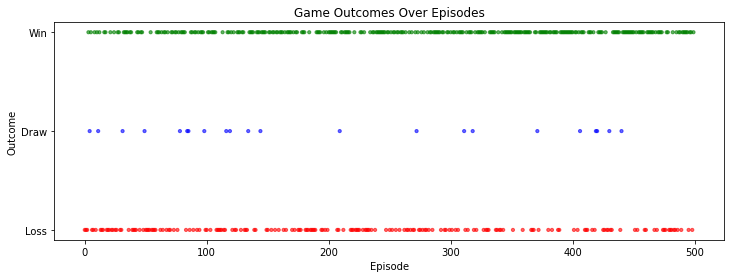

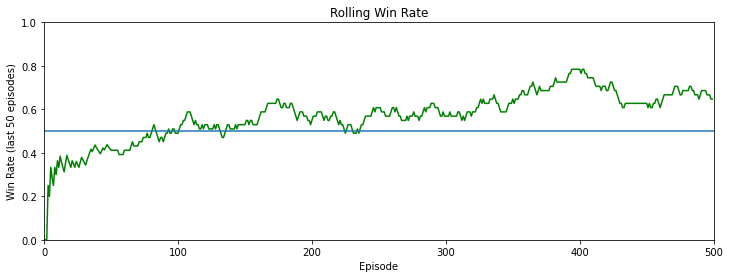

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# results is a list of 1=Win, 0=Draw, -1=Loss
results_array = np.array(results)

# -----------------------------
# Option 1: Color-coded scatter plot
# -----------------------------
colors = ['green' if r==1 else 'red' if r==-1 else 'blue' for r in results_array]

plt.figure(figsize=(12,4))
plt.scatter(range(len(results_array)), results_array, c=colors, alpha=0.6, s=10)
plt.yticks([-1,0,1], ['Loss','Draw','Win'])
plt.xlabel('Episode')
plt.ylabel('Outcome')
plt.title('Game Outcomes Over Episodes')
plt.show()

# -----------------------------
# Option 2: Rolling win-rate (smoother)
# -----------------------------
window = 50  # rolling window
win_rate = [np.mean(results_array[max(0,i-window):i+1]==1) for i in range(len(results_array))]

plt.figure(figsize=(12,4))
plt.plot(win_rate, color='green')
plt.plot((0,len(results)),(.5,.5))
plt.xlabel('Episode')
plt.ylabel('Win Rate (last 50 episodes)')
plt.title('Rolling Win Rate')
plt.ylim(0,1)
plt.xlim(0,len(results))
plt.show()

In [20]:
print("The following is the list of snapshots")
print("Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.")
'''snapshot = {

"My_Mana": [self.mana]*length,
"Their_Mana": [opponent.mana]*length,
"My_Health": [self.base_health]*length,
"Their_Health": [opponent.base_health]*length,
"Their_Card_Types_Seen":encodehand(enemy_list) ,
"Their_Currently_Visible_Cards": encodedeployed(opponent.available_squares),
"Active_Cards":encodedeployed(self.available_squares),
"Deck":encodehand(self.deck),
"Action Taken":encodemove(self.move)
}'''
import torch

mvs=sim.p2b.get_possible_moves(sim.p2b.game)
encodemoves([mv.movename for mv in mvs ])

The following is the list of snapshots
Columns contain both players' health, both players' mana, and one-hot encoded lists of cards in hand.


AttributeError: 'simulator' object has no attribute 'p2b'

In [ ]:
allmoves